# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.


In [1]:
# !pip install datasets

Импорт необходимых библиотек


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

from IPython.display import clear_output
from copy import deepcopy

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/ioann/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = torch.device("mps") if torch.backends.mps.is_available() else (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
device

device(type='mps')

## Подготовка данных

Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.


In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Found cached dataset ag_news (/Users/ioann/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

Как и в семинаре, выполним следующие шаги:

- Составим словарь
- Создадим класс WordDataset
- Выделим обучающую и тестовую часть, создадим DataLoader-ы.


In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
  # Приводим к нижнему регистру и убираем пунктуацию
  processed_text = example.lower().translate(
      str.maketrans('', '', string.punctuation))

  for word in word_tokenize(processed_text):
    words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
  if cnt > counter_threshold:
    vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [7]:
class WordDataset:
  def __init__(self, sentences):
    self.data = sentences
    self.unk_id = word2ind['<unk>']
    self.bos_id = word2ind['<bos>']
    self.eos_id = word2ind['<eos>']
    self.pad_id = word2ind['<pad>']

  def __getitem__(self, idx: int) -> List[int]:
    processed_text = self.data[idx]['text'].lower().translate(
        str.maketrans('', '', string.punctuation))
    tokenized_sentence = [self.bos_id]
    tokenized_sentence += [
        word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
    ]
    tokenized_sentence += [self.eos_id]

    train_sample = {
        "text": tokenized_sentence,
        "label": self.data[idx]['label']
    }

    return train_sample

  def __len__(self) -> int:
    return len(self.data)


def collate_fn_with_padding(
        input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
  seq_lens = [len(x['text']) for x in input_batch]
  max_seq_len = min(max(seq_lens), max_len)

  new_batch = []
  for sequence in input_batch:
    sequence['text'] = sequence['text'][:max_seq_len]
    for _ in range(max_seq_len - len(sequence['text'])):
      sequence['text'].append(pad_id)

    new_batch.append(sequence['text'])

  sequences = torch.LongTensor(new_batch).to(device)
  labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

  new_batch = {
      'input_ids': sequences,
      'label': labels
  }

  return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 128
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи

Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.


In [9]:
def evaluate(model, eval_dataloader) -> float:
  """
  Calculate accuracy on validation dataloader.
  """

  predictions = []
  target = []
  with torch.no_grad():
    for batch in eval_dataloader:
      logits = model(batch['input_ids'])
      predictions.append(logits.argmax(dim=1))
      target.append(batch['label'])

  predictions = torch.cat(predictions)
  target = torch.cat(target)
  accuracy = (predictions == target).float().mean().item()

  return accuracy

## Ход работы

Оценка за домашнее задание складывается из четырех частей:

### Запуск базовой модели с семинара на новом датасете (1 балл)

На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)

Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:

- **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
- **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
- **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
- **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)

В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:

- $accuracy < 0.9$ --- 0 баллов;
- $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
- $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
- $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)

В конце работы подробно опишите все проведенные эксперименты.

- Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
- Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
- Укажите, какая модель получилась оптимальной.

Желаем удачи!


---

# Student's part


Зафиксируем состояние генератора рандомных числе для воспроизводимости результатов.


In [10]:
SEED = 2_147_483_647
torch.manual_seed(SEED)

## Baseline model


### Model architecture


In [11]:
class SimpleRNN(nn.Module):
  def __init__(self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
               aggregation_type: str = "max", num_layers: int = 1, dropout_rate: float = 0.1):

    super().__init__()
    self.embedding = nn.Embedding(vocab_size, hidden_dim)
    self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_dim, hidden_dim)
    self.projection = nn.Linear(hidden_dim, num_classes)

    self.non_lin = nn.Tanh()
    self.dropout = nn.Dropout1d(p=dropout_rate)
    self.aggregation_type = aggregation_type

  def forward(self, x) -> torch.Tensor:

    embeddings = self.embedding(x)
    output, _ = self.rnn(embeddings)
    if self.aggregation_type == "max":
      output = output.max(dim=1)[0]
    elif self.aggregation_type == "mean":
      output = output.mean(dim=1)
    else:
      raise ValueError("Invalid aggregation type")

    output = self.dropout(self.linear(self.non_lin(output)))
    prediction = self.projection(self.non_lin(output))

    return prediction

### Training procedure


In [12]:
def plot_history(history, model):

  fig, axs = plt.subplots(1, 2, figsize=(10, 4))
  fig.suptitle(model.__class__.__name__)

  ax = axs[0]
  ax.plot(history["train_loss"], label="Train loss")
  ax.plot(history["valid_loss"], label="Valid loss")
  ax.set(xlabel="epoch", title="Loss")
  ax.legend(loc="best")

  ax = axs[1]
  ax.plot(history["score"])
  ax.set(xlabel="epoch", title="Accuracy score")

  fig.tight_layout()
  plt.show()

In [13]:
def train_loop(model, criterion, optimizer, num_epochs: int = 5):

  best_score = 0
  history = {"train_loss": [], "valid_loss": [], "score": []}

  for epoch in range(num_epochs):

    avg_train_loss = 0
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Training (e{epoch+1}) --> ")):

      optimizer.zero_grad()

      inputs = batch["input_ids"]
      labels = F.one_hot(batch["label"], num_classes=4).to(torch.float32)
      logits = model(inputs)
      loss = criterion(logits, labels)

      loss.backward()
      optimizer.step()

      avg_train_loss += loss.item() / len(train_dataloader)
    history["train_loss"].append(avg_train_loss)

    avg_valid_loss = 0
    model.eval()
    with torch.no_grad():
      for i, batch in enumerate(tqdm(eval_dataloader, desc=f"Validation (e{epoch+1}) -->  ")):

        inputs = batch["input_ids"]
        labels = F.one_hot(batch["label"], num_classes=4).to(torch.float32)
        logits = model(inputs)
        loss = criterion(logits, labels)

        avg_valid_loss += loss.item() / len(eval_dataloader)
    history["valid_loss"].append(avg_valid_loss)

    accuracy_score = evaluate(model, eval_dataloader)
    history["score"].append(accuracy_score)
    if best_score < accuracy_score:
      best_score = accuracy_score
      best_model_wts = deepcopy(model.state_dict())

    clear_output()
    plot_history(history, model)
  model.load_state_dict(best_model_wts)

  return model, history

### Baseline model


In [14]:
simple_rnn = SimpleRNN(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(simple_rnn.parameters(), lr=1e-4)

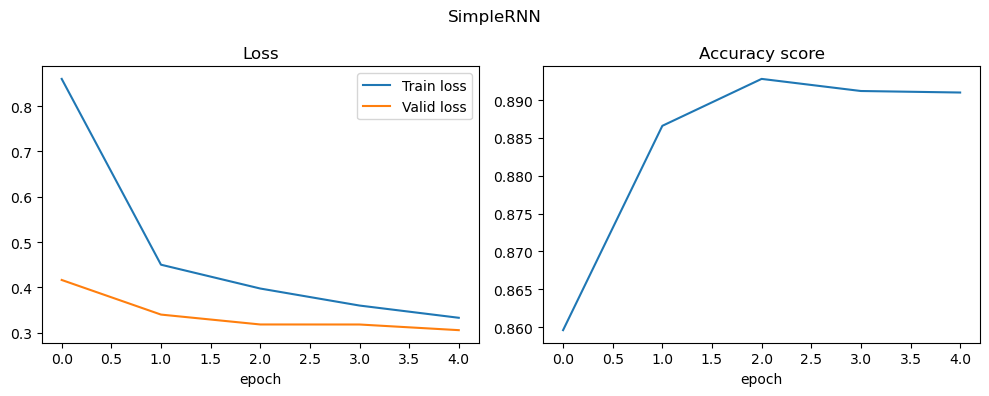

In [15]:
model, history = train_loop(simple_rnn, criterion, optimizer)